**<h1><center>State Farm Classification Exercise</h1>**

**Name: Anitha Ganapathy** <br>
**Email: anitha.g19@gmail.com** <br>


___

# ML Classification

## Organize Imports

In [1]:
# !pip install sklearn_pandas
# !pip install git+git://github.com/scikit-learn/scikit-learn.git
# ! pip install https://github.com/scikit-learn/scikit-learn/archive/master.zip

In [2]:
# !pip install -U scikit-learn   # updated it for categorical imputer but didnt work

In [3]:
#import some basic libraries

import numpy as np
import pandas as pd
import random
import math

import time
import matplotlib.pyplot as plt
import seaborn as sns

# dealing with imbalanced dataset
# import library
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Pipelines
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector as selector
# from sklearn_pandas import CategoricalImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score



# imports for neural network using kearas and tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')



# display settings

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


In [4]:
dirpath = '/content/drive/MyDrive/DS_Exercise/'
!ls $dirpath

'Classification Exercise Instructions.txt'    nonglmresults.csv
 exercise_40_test.csv			      SF_exercise_v1.ipynb
 exercise_40_train.csv			      SF_exercise_v2.ipynb
 glmresults.csv				      SF_exercise_v3.ipynb
'Group1_Phase3_PyTorch Deep Learning.ipynb'


## Load data

In [5]:
df_train = pd.read_csv(dirpath + 'exercise_40_train.csv' )
df_predict = pd.read_csv(dirpath + 'exercise_40_test.csv' )

In [6]:
df_train.shape , df_predict.shape

((40000, 101), (10000, 100))

## separate the y label from the train dataset

In [7]:
y_label = df_train['y']
df_train = df_train.drop(columns=['y'], axis= 1)

df_train.shape, y_label.shape

((40000, 100), (40000,))

## Split train and test data

split the data to avoid data leakeage and reset the index using reset_index()

In [8]:
seed = 999
X_train, X_test, y_train, y_test = train_test_split(df_train, y_label, test_size=.2, random_state = seed,
                                                     shuffle=True, stratify=y_label)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## User defines class and functions


### Class : DropConstantValColumns

In [9]:
# Transformer class to drops columns with single dictinct values in the dataframe

class DropConstantValColumns(BaseEstimator ,TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """

    def fit(self, X, y=None):
        self.cols_to_drop = []
        for col in X.columns:
          if X[col].nunique() == 1:
            self.cols_to_drop.append(col)
        return self

    def transform(self, X, y=None):
      return X.drop(columns = self.cols_to_drop, axis = 1)

### Class : DataFrameImputer

In [10]:
# This class acts as a imputer for both numerial and categorical datatypes
# Categorical data is replaced with the most common value
# numerical data is replaced with the mean value

# link : https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn/25562948#25562948
# alternate solution : https://www.geeksforgeeks.org/pandas-filling-nan-in-categorical-data/


# class DataFrameImputer(BaseEstimator ,TransformerMixin):

#     def __init__(self):
#         """Impute missing values.

#         Columns of dtype object are imputed with the most frequent value 
#         in column.

#         Columns of other types are imputed with mean of column.

#         """
#     def fit(self, X, y=None):
#         self.fill = pd.Series([X[c].value_counts().index[0]
#             if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
#             index=X.columns)
#         return self

#     def transform(self, X, y=None):
#         return X.fillna(self.fill)


class DataFrameImputer(BaseEstimator ,TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].fillna("Missing")
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

### Class : WeekFullName

In [11]:
# Transformer class to remove special charaters from the specific columns of a dataframe

class WeekFullName(BaseEstimator ,TransformerMixin):

    def __init__(self):
      self.week_short_full = { 'x3' : { 'Mon':'Monday',
                                        'Tue':'Tuesday',
                                        'Wed':'Wednesday',
                                        'Thur': 'Thursday',
                                        'Fri': 'Friday',
                                        'Sat': 'Saturday',
                                        'Sun': 'Sunday' }
                              } 

    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        # replace the short week days name to full names
        X = X.replace(self.week_short_full)      
        return X




### Class : RemoveSpecialChar_x7

In [12]:
# Transformer class to remove special charaters from the specific columns of a dataframe

class RemoveSpecialChar_x7(BaseEstimator ,TransformerMixin):

    def __init__(self):
      self.col = ['x7']

    def fit(self, X, y=None):
        return self

    def transform(self, X,):
        # remove the special characters from the column values
        val = pd.Series(X[self.col].values.flatten())
        X[self.col] = pd.DataFrame([v.replace(r'%', '') for v in val ]).astype(float)
        return X

### Class : RemoveSpecialChar_x19

In [13]:
# Transformer class to remove special charaters from the specific columns of a dataframe

class RemoveSpecialChar_x19(BaseEstimator ,TransformerMixin):

    def __init__(self):
      self.col = ['x19']

    def fit(self, X, y=None):
        return self

    def transform(self, X,):
        # remove the special characters from the column values
        val = pd.Series(X[self.col].values.flatten())
        X[self.col] = pd.DataFrame([v.replace(r'$', '') for v in val ]).astype(float)
        return X

### Class : getdummies for categorical columns

In [14]:
# Transformer class to convert categorical columns to dummy numerical columns using get_dummies()

class GetDummies(BaseEstimator ,TransformerMixin):

    def __init__(self):
      pass
      
    def fit(self, X, y=None):
        self.object_columns = list(X.select_dtypes(include=['object']).columns)
        return self

    def transform(self, X, y=None):
      new_cols  = pd.get_dummies(X[self.object_columns])
      X_full = pd.merge(X.drop(columns= self.object_columns, axis= 1), new_cols, left_index=True, right_index=True)
      # print(X_full)
      return X_full


**Alternate solution to get_dummies()**

```
# OHE using OneHotEncoder from sklearn

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
data_transformed = encoder.fit_transform(X_train[object_columns])

# create a df with new features and fetch the new column names
new_cols_ohe = pd.DataFrame(data_transformed.toarray(), columns= encoder.get_feature_names_out())

# merge the new features to the original dataset
X_train_full_ohe = pd.merge(X_train.drop(columns= object_columns, axis= 1), new_cols_ohe, left_index=True, right_index=True)
```

### Functions

In [15]:
 # Helper function

def cat_features_plot(df, categorical_col):
    
    plot_x = int(len(categorical_col)/2)
    fig, ax = plt.subplots(plot_x, 2, figsize=(12, 20))
    
    num = 0
    for i in range(0, plot_x):
        for j in range(0,2):
            tst = sns.countplot(x=categorical_col[num],
                                data=df ,
                                order = df[categorical_col[num]].value_counts().index,
                                ax=ax[i][j], palette='muted')
            tst.set_title(f"Distribution of the {categorical_col[num]}  Variable.")
            tst.set_xticklabels(tst.get_xticklabels(), rotation=90, fontsize = 8)
            plt.subplots_adjust(left=None, bottom=None, right=None,
                        top=None, wspace=None, hspace=0.45)
            num = num + 1
            plt.tight_layout() 

week_short_full = { 'x3' : { 'Mon':'Monday',
                          'Tue':'Tuesday',
                          'Wed':'Wednesday',
                          'Thur': 'Thursday',
                          'Fri': 'Friday',
                          'Sat': 'Saturday',
                          'Sun': 'Sunday' }
                   }  

# Drop the column with constant values / single distinct value
def cols_with_same_val_to_drop(df): 
  cols_to_drop = []
  for col in X_train.columns:
    if X_train[col].nunique() ==1:
      cols_to_drop.append(col)
  #print("Columns to drop are : ", cols_to_drop)
  return cols_to_drop


def getdummies(df, cols):
  return pd.get_dummies(df[cols])

def plot_loss_accuracy(hist,n_epochs, txt ):
  epochs = range(0, n_epochs)

  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)

  plt.plot(epochs, hist.history['loss'], '-', label='Training loss')
  plt.plot(epochs, hist.history['val_loss'], ':', label='Validation loss')
  plt.title(txt + 'Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(epochs, hist.history['accuracy'], '-', label='Training accuracy')
  plt.plot(epochs, hist.history['val_accuracy'], ':', label='Validation accuracy')
  plt.title(txt + ' Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()


def plot_auc_roc_curve(fpr, tpr, score , txt):
  #create ROC curve
  plt.plot(fpr,tpr)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f"{txt} : {score}")
  plt.show()  

## Exploratory Data Analysis

### make a deep copy of the X_train dataset

In [16]:
%%time

X_train_eda = X_train.copy(deep = True)

CPU times: user 5.31 ms, sys: 18.8 ms, total: 24.1 ms
Wall time: 24.4 ms


**Data Initial Analysis**
<br>There are 100 columns with mixed data types as below:
<br>1. float64(86), 
<br>2. int64(2), 
<br>3. object(12) 

<br> Float and int64 dtypes are good to run ML algorithms but the object datatypes need to be converted to intereger for the data to be fit for ML agorithms.

In [17]:
X_train_eda.dtypes.value_counts()

float64    86
object     12
int64       2
dtype: int64

### Y label distribution

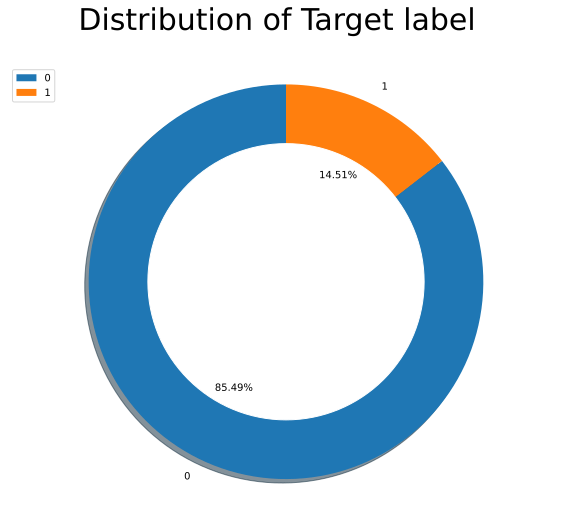

In [18]:
fig, ax = plt.subplots(figsize =(10, 8))

plt.pie(y_label.value_counts(), labels=list(y_label.value_counts().index),
        autopct='%1.2f%%',
        shadow=True, startangle=90)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('equal')
plt.suptitle("Distribution of Target label",fontsize=30, ha='center')
ax.legend(bbox_to_anchor =(1, 0))
plt.legend(loc="upper left")
plt.show()

### Plotting the feature type distribution

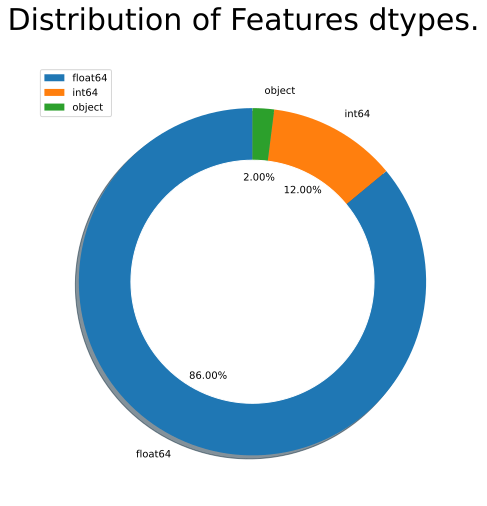

In [19]:
fig, ax = plt.subplots(figsize =(10, 8))
data = X_train_eda.dtypes.value_counts()
plt.pie(data, autopct='%1.2f%%',labels=['float64','int64','object'],
        shadow=True, startangle=90)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
# plt.axis('equal')

# ax.set_title("Customizing pie chart",fontsize=20, ha='center')
plt.suptitle("Distribution of Features dtypes.",fontsize=30, ha='center')
ax.legend(bbox_to_anchor =(1, 0))
plt.legend(loc="upper left")
plt.show()

### Separate numerical and object type columns

In [20]:
numerical_columns = list(X_train_eda.select_dtypes(exclude=['object']).columns) 
object_columns = list(X_train_eda.select_dtypes(include=['object']).columns)
len(object_columns) , len(numerical_columns)

(12, 88)

In [21]:
X_train_eda[object_columns].head()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Thursday,0.0053%,$502.812467633606,male,yes,Texas,5-10 miles,June,progressive,NaN,no,yes
1,Sunday,-0.0076%,$400.173282774155,NaN,no,Colorado,5-10 miles,January,progressive,subaru,no,yes
2,Saturday,-6e-04%,$1649.93461915731,male,no,Texas,5-10 miles,July,progressive,NaN,no,yes
3,Monday,0.0072%,$271.316186697522,male,no,Kentucky,5-10 miles,December,allstate,ford,no,NaN
4,Wednesday,-0.0025%,$691.218740386437,female,no,Illinois,5-10 miles,August,progressive,NaN,no,NaN


### Basic stats of the data

In [22]:
X_train_eda[numerical_columns].describe()

,x1,x2,x4,x5,x6,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x20,x21,x22,x23,x25,x26,x27,x28,x29,x30,x32,x34,x35,x36,x37,x38,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x61,x62,x63,x64,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,32000.000000,32000.000000,32000.000000,30066.000000,32000.000000,32000.000000,32000.000000,32000.000000,27866.000000,32000.000000,32000.000000,24163.000000,32000.000000,23020.000000,32000.000000,32000.000000,32000.000000,32000.000000,30081.000000,32000.000000,32000.000000,30076.000000,32000.000000,32000.000000,32000.000000,6159.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,30077.000000,32000.000000,24381.000000,24187.000000,32000.000000,4595.000000,25532.000000,32000.000000,32000.000000,32000.000000,21719.000000,32000.000000,32000.000000,19091.000000,32000.000000,21764.000000,17795.000000,32000.000000,6073.000000,32000.000000,32000.000000,26235.000000,32000.000000,30059.000000,27906.000000,32000.000000,30044.000000,30074.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,21758.000000,27771.000000,27806.000000,22871.000000,30081.000000,27787.000000,32000.000000,32000.000000,30067.000000,32000.000000,24188.000000,30129.000000,32000.000000,30133.000000,23412.000000,32000.000000,27810.000000,30019.000000,30119.000000,21929.000000,26702.000000,32000.000000,32000.000000,32000.000000
mean,3.002499,20.002054,0.001379,0.008592,0.006531,0.005451,2.722676,0.489989,100.020754,3.033877,3.888003,0.789786,0.009432,100.696824,8.007752,79.925350,4.974935,11.008454,72.015081,0.203804,4.976013,0.003817,999.460871,15.014747,1.005907,0.015394,0.555399,52.988664,1.366067,70.012851,31.010119,35.954611,14.951630,99991.590586,0.648989,0.504696,1.102508,0.559782,0.019960,49.978796,60.009069,10.305371,2103.337205,1.478995,5.041016,69.958210,-0.002763,3.007215,0.499416,32.630651,300.420111,0.099312,10.021851,3.823345,-0.005616,50.018633,-0.002742,14.415674,14.969584,0.000572,0.737248,0.000815,49.946009,6.930454,-0.006415,1.426181,-1.027350,49.921827,0.898640,10.029637,0.018982,-6.101514,3.821840,2.140514,99.992429,49.982312,-0.005447,0.449362,10.764955,2.994795,-0.004700,3.999583,3.962196,0.037332,10.519332,10.001986,0.498375,100.019449
std,1.998766,1.604544,1.463222,1.297349,1.361108,1.448467,1.964147,1.030698,13.384919,3.579343,2.671557,0.752524,1.478555,1.057302,2.263436,6.514201,3.548244,15.611347,26.842716,1.018328,2.437538,1.562532,104.204562,3.656036,1.419461,1.570107,1.904676,5.823144,1.682382,4.270112,3.406972,26.133793,3.248122,1348.589592,1.162167,1.036028,1.628329,1.207210,1.776132,4.435989,5.501539,2.702519,949.436938,1.580478,7.246518,4.979079,1.356584,1.837221,1.451658,8.422676,35.029074,0.299086,3.440411,2.236148,1.518505,5.007991,1.476108,1.156097,6.360751,1.348984,0.368127,0.423262,6.505025,5.591079,1.444136,2.415934,1.215176,4.175538,0.301809,2.570941,1.552334,2.285133,2.519080,0.780563,10.455121,4.820923,1.186394,1.093856,3.727102,1.166452,1.471053,3.016261,1.478141,1.821180,1.440827,1.987219,0.500005,5.247835
min,-3.648431,14.174437,-5.137161,-5.175900,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,-5.846331,-2.474185,-0.338985,-6.141315,99.131018,-1.059815,66.756855,-9.561032,-3.819778,4.263648,-3.943834,-2.489909,-5.857922,604.067215,-1.074573,-4.165802,-4.775358,-3.966788,29.351461,-3.500424,52.327899,17.179476,-4.198270,9.999943,94236.454769,-1.187438,-4.538490,-3.697254,-1.318996,-7.269258,32.894868,38.724108,0.521112,-1630.227579,-3.523781,-23.955783,47.976420,-5.191496,0.248284,-5.457856,13.882758,98.897817,0.000000,1.610473,-3.990470,-13.864450,29.918688,-6.715834,4.313964,0.400312,-5.297159,0.008685,-4.150203,25.222808,-3.295149,-5.364030,-3.803147,-7.818713,29.904840,0.000000,2.361436,-5.852824,-11.847968,-2.754698,-2.768332,58.377629,30.681184,-5.237572,-4.580025,6.106024,-2.173310,-6.328126,-3.384399,-1.663063,-6.885150,8.2104

In [23]:
X_train_eda[object_columns].describe()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
count,32000,32000,32000,28867,32000,26260,32000,32000,32000,24612,32000,21697
unique,14,649,32000,2,2,51,1,12,5,7,2,1
top,Wednesday,0.0022%,$502.812467633606,female,no,California,5-10 miles,December,allstate,ford,no,yes
freq,3937,155,1,14527,27268,2687,32000,6503,8729,7219,28422,21697


In [24]:
X_train_eda[object_columns].head(10)

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Thursday,0.0053%,$502.812467633606,male,yes,Texas,5-10 miles,June,progressive,NaN,no,yes
1,Sunday,-0.0076%,$400.173282774155,NaN,no,Colorado,5-10 miles,January,progressive,subaru,no,yes
2,Saturday,-6e-04%,$1649.93461915731,male,no,Texas,5-10 miles,July,progressive,NaN,no,yes
3,Monday,0.0072%,$271.316186697522,male,no,Kentucky,5-10 miles,December,allstate,ford,no,NaN
4,Wednesday,-0.0025%,$691.218740386437,female,no,Illinois,5-10 miles,August,progressive,NaN,no,NaN
5,Monday,0.0069%,$1845.33063316388,male,no,South Carolina,5-10 miles,August,allstate,NaN,no,NaN
6,Saturday,0.0018%,$-206.693845457496,NaN,no,Ohio,5-10 miles,August,geico,mercedes,no,yes
7,Tuesday,-0.007%,$-2951.08648655358,female,no,NaN,5-10 miles,August,geico,mercedes,no,yes
8,Monday,7e-04%,$-258.002990423575,female,no,NaN,5-10 miles,March,geico,NaN,no,yes
9,Tuesday,0.0133%,$286.244302268957,NaN,no,Arkansas,5-10 miles,May,farmers,toyota,no,yes


we observe the x7 and x19 are numerical columns with added special characters , we can drop these columns from the category list so that the 2 columns can be preprocessed later

In [25]:
X_train_eda.drop(columns= ['x7', 'x19'], axis= 1, inplace= True)
object_columns = list(set(object_columns) - set(['x7', 'x19']))
X_train_eda[object_columns].head()

,x99,x33,x77,x60,x39,x65,x31,x93,x3,x24
0,yes,Texas,NaN,June,5-10 miles,progressive,yes,no,Thursday,male
1,yes,Colorado,subaru,January,5-10 miles,progressive,no,no,Sunday,NaN
2,yes,Texas,NaN,July,5-10 miles,progressive,no,no,Saturday,male
3,NaN,Kentucky,ford,December,5-10 miles,allstate,no,no,Monday,male
4,NaN,Illinois,NaN,August,5-10 miles,progressive,no,no,Wednesday,female


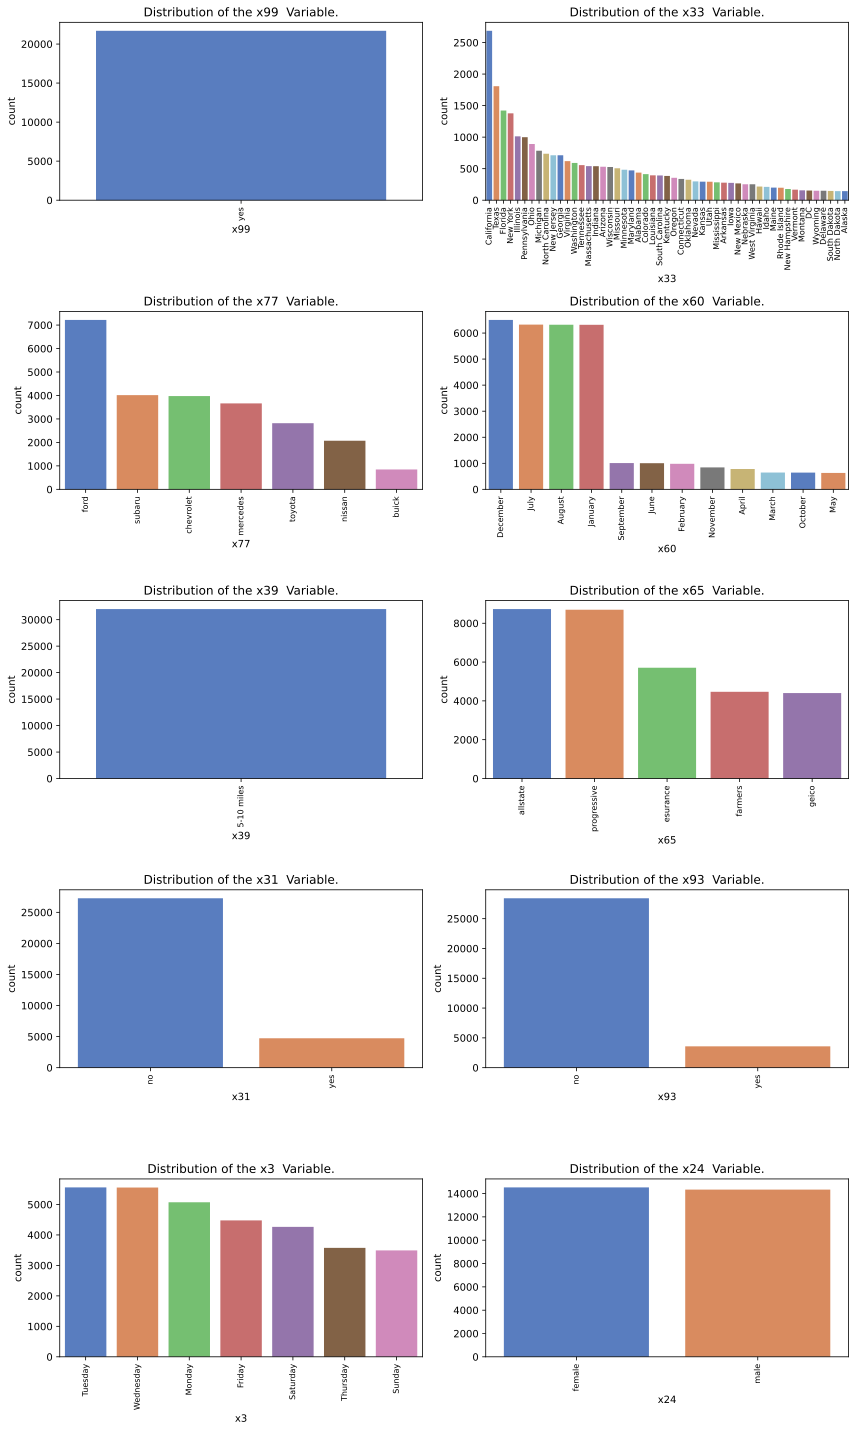

In [26]:
# replace the short week days name to full names
X_train_eda.replace(week_short_full, inplace=True)  

cat_features_plot(X_train_eda, object_columns)

In [27]:
# pairplot_data = X_train_eda.copy(deep = True)
# pairplot_data['y'] = y_train
# sns.pairplot(pairplot_data , hue = 'y')

we can observe that 2 columns (x39 and x99) have a constant values, which we can drop as it does not serve our purpose

## X_train dataset preprocessing

### Logistic Regression Pipeline

- Step 1: Drop the column with constant values / single distinct value
- Step 2: Dataframe imputer (combine the numerical and categorical imputer)
- Step 3: Individual column transformation
- step 4: getdummies(convert categorical to dummy variables)

**Object type columns observation**


**Column x3**
<br>
- first idea :This column holds the days of the week so we can convert it to category column that hold interger values from 1 to 7 
- Second idea: Convert the short form to full weekdays names, and assign them to be categorical so that we can use get_dummies() for conversion to  dummy/indicator variables 

**Column x7, x19**
<br>
-  x7 holds % sign at the end
- x19 hold $ at the beginning

**Column x24, x31, x33, x60, x65, x77, and x93**
<br>
-  assign them as categorical column and use get_dummies() for convert them to  dummy/indicator variables



#### Just checking the data after transformation before applying scaler and classifier

In [28]:
data = Pipeline([
        ('drop_constant_val_cols', DropConstantValColumns()),
        ('imputer', DataFrameImputer()),
        ('WeekFullName', WeekFullName()),
        ('RemoveSpecialChar_x7', RemoveSpecialChar_x7()),
        ('RemoveSpecialChar_x19', RemoveSpecialChar_x19()),
        ('getdummies', GetDummies()),
])

X_train_transformed = data.fit_transform(X_train, y_train)

## Create a log of experiments

In [29]:
experiments = pd.DataFrame(columns=['Clf_name', 'AUC_ROC_score'])
experiments

,Clf_name,AUC_ROC_score


## Handle Imbalanced Dataset


#### Showcasing the results of SMOTE
Synthetic Minority Oversampling Technique (SMOTE)

In [30]:
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train_transformed, y_train)

print('Original dataset shape', y_train.value_counts())
print('Resample dataset shape',  y_smote.value_counts())

Original dataset shape 0    27358
1     4642
Name: y, dtype: int64
Resample dataset shape 0    27358
1    27358
Name: y, dtype: int64


In [31]:
%%time
# https://stackoverflow.com/questions/72749144/scikit-learn-pipeline-with-smote


LR_pipeline = Pipeline([
        ('drop_constant_val_cols', DropConstantValColumns()),
        ('imputer', DataFrameImputer()),
        ('WeekFullName', WeekFullName()),
        ('RemoveSpecialChar_x7', RemoveSpecialChar_x7()),
        ('RemoveSpecialChar_x19', RemoveSpecialChar_x19()),
        ('getdummies', GetDummies()),
        ('scaler', MinMaxScaler()),
        ('smote',SMOTE(k_neighbors=500 ,random_state = seed)),
        ("log_regression", LogisticRegression( n_jobs = 4 , max_iter = 1000,verbose = 1))
    ])

# fit the model
lr_model = LR_pipeline.fit(X_train, y_train)

# # Arrange grid search parameters for each classifier
# params_grid =  {
#                     # 'log_regression__penalty': ( 'l2', 'elasticnet'),
#                     # 'log_regression__tol': (0.0001, 0.00001), 
#                     'log_regression__C': (1, 0.001),
#                     # 'log_regression__solver' : ('lbfgs',)
#                 }
              

# model_lr = GridSearchCV(LR_pipeline ,params_grid )
# model_lr.fit(X_train, y_train)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 2.45 s, sys: 300 ms, total: 2.75 s
Wall time: 1min 23s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.4min finished


### Logistic regression: predict the probabilities 

In [32]:
# predict the test data
y_pred_lr = lr_model.predict_proba(X_test)
roc_lr = roc_auc_score(y_test, y_pred_lr[:, 1])
print("roc_auc_score score on the test set :   ", roc_auc_score(y_test, y_pred_lr[:, 1]))
print("Model score on train set :  ", lr_model.score(X_train, y_train))
print("Model score on test set :  ", lr_model.score(X_test, y_test))


roc_auc_score score on the test set :    0.7638474377899767
Model score on train set :   0.7021875
Model score on test set :   0.707375


In [33]:
experiments.loc[len(experiments)] = ["Logistic Regression", roc_lr]
experiments

,Clf_name,AUC_ROC_score
0,Logistic Regression,0.763847


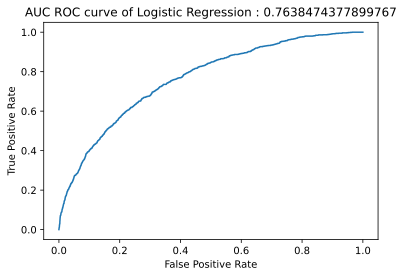

In [34]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_lr[:,1])

plot_auc_roc_curve(fpr, tpr,roc_lr, "AUC ROC curve of Logistic Regression")  

### Write the predicted values to csv file 'glmresults.csv'

In [35]:
y_prediction = lr_model.predict_proba(df_predict)

pd.DataFrame(y_prediction[:,1]).to_csv(dirpath + "/glmresults.csv", index= False)

### Random Forest Classifier Pipeline

In [36]:
%%time

RF_pipeline = Pipeline([
        ('drop_constant_val_cols', DropConstantValColumns()),
        ('imputer', DataFrameImputer()),
        ('WeekFullName', WeekFullName()),
        ('RemoveSpecialChar_x7', RemoveSpecialChar_x7()),
        ('RemoveSpecialChar_x19', RemoveSpecialChar_x19()),
        ('getdummies', GetDummies()),
        ('scaler', MinMaxScaler()),
        ('smote',SMOTE(k_neighbors=500 ,random_state = seed)),
        ("random_forest_clf", RandomForestClassifier(n_estimators = 200,  n_jobs = 4,verbose = 1))
    ])

# fit the model
rf_model = RF_pipeline.fit(X_train, y_train)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min


CPU times: user 2min 44s, sys: 487 ms, total: 2min 45s
Wall time: 1min 44s


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.7min finished


#### Random Forest: predict the probabilities 

In [37]:
# predict the test data
y_pred_rf = rf_model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [38]:
roc_rf = roc_auc_score(y_test, y_pred_rf[:, 1])
print("roc_auc_score score on the test set :   ", roc_auc_score(y_test, y_pred_rf[:, 1]))
print("Model score on train set :  ", rf_model.score(X_train, y_train))
print("Model score on test set :  ", rf_model.score(X_test, y_test))


roc_auc_score score on the test set :    0.7496742160877744


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Model score on train set :   1.0


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Model score on test set :   0.843625


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


In [39]:
experiments.loc[len(experiments)] = ["Random Forest ", roc_rf]
experiments

,Clf_name,AUC_ROC_score
0,Logistic Regression,0.763847
1,Random Forest,0.749674


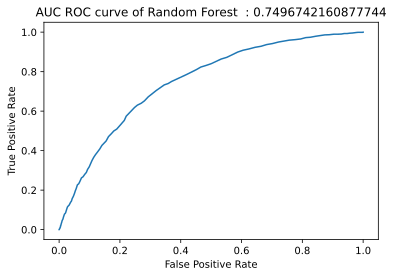

In [40]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_rf[:, 1])

plot_auc_roc_curve(fpr, tpr, roc_rf, "AUC ROC curve of Random Forest ")  

### Write the predicted values to csv file 'nonglmresults.csv'

In [41]:
y_prediction_rf = rf_model.predict_proba(df_predict)

pd.DataFrame(y_prediction_rf[:,1]).to_csv(dirpath + "/nonglmresults.csv" , index= False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


## Deep learning for classification

### Input preprocessing pipeline


In [33]:
pre_processing = Pipeline([ ('drop_constant_val_cols', DropConstantValColumns()),
                            ('imputer', DataFrameImputer()),
                            ('WeekFullName', WeekFullName()),
                            ('RemoveSpecialChar_x7', RemoveSpecialChar_x7()),
                            ('RemoveSpecialChar_x19', RemoveSpecialChar_x19()),
                            ('getdummies', GetDummies()),
                            # ('smote',SMOTE(k_neighbors=500 ,random_state = seed)),
                            ('scaler', MinMaxScaler()),
                            
                        ])

X_train_processed = pre_processing.fit_transform(X_train, y_train)
X_test_processed = pre_processing.fit_transform(X_test, y_test)

In [34]:
X_train_processed.shape , X_test_processed.shape

((32000, 181), (8000, 181))

### NN Model definition

In [44]:
nn_model = Sequential()
# nn_model.add(Dense(250, activation='relu', kernel_initializer="he_normal", input_shape=(None, X_train_processed.shape[1])))
nn_model.add(Dense(20, activation='relu',  kernel_initializer="he_normal",  input_dim= X_train_processed.shape[1]))
nn_model.add(Dropout(0.7))
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                3640      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,861
Trainable params: 3,861
Non-trainable params: 0
_________________________________________________________________


In [45]:
n_epochs = 500
batch_size=12

nn_hist = nn_model.fit(X_train_processed, y_train, validation_data = (X_test_processed, y_test) , epochs = n_epochs, batch_size =batch_size, verbose = 1)

Epoch 1/500
2667/2667 [==============================] - 18s 5ms/step - loss: 0.4511 - accuracy: 0.8495 - val_loss: 0.4128 - val_accuracy: 0.8549
Epoch 2/500
2667/2667 [==============================] - 13s 5ms/step - loss: 0.4159 - accuracy: 0.8549 - val_loss: 0.4071 - val_accuracy: 0.8549
Epoch 3/500
2667/2667 [==============================] - 12s 4ms/step - loss: 0.4113 - accuracy: 0.8549 - val_loss: 0.4029 - val_accuracy: 0.8549
Epoch 4/500
2667/2667 [==============================] - 11s 4ms/step - loss: 0.4066 - accuracy: 0.8549 - val_loss: 0.3999 - val_accuracy: 0.8549
Epoch 5/500
2667/2667 [==============================] - 14s 5ms/step - loss: 0.4039 - accuracy: 0.8549 - val_loss: 0.3972 - val_accuracy: 0.8549
Epoch 6/500
2667/2667 [==============================] - 12s 5ms/step - loss: 0.4028 - accuracy: 0.8549 - val_loss: 0.3912 - val_accuracy: 0.8549
Epoch 7/500
2667/2667 [==============================] - 12s 4ms/step - loss: 0.3995 - accuracy: 0.8549 - val_loss: 0.3937 -

#### Plot the loss and accuracy curve for train vs test

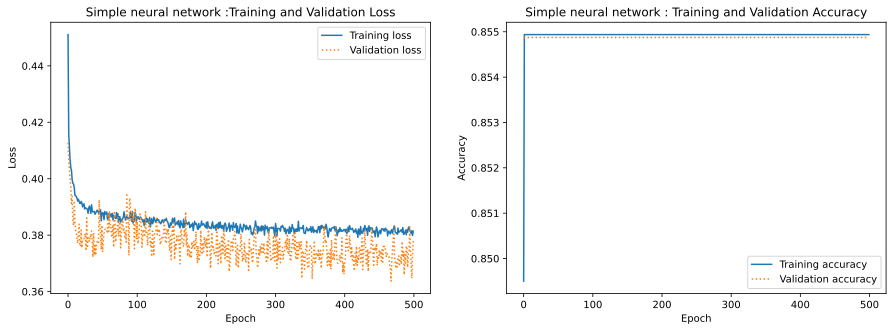

In [46]:
plot_loss_accuracy(nn_hist,n_epochs, "Simple neural network :" )

#### NN model prediction

In [47]:
# predict the test data
y_pred_nn = nn_model.predict(X_test_processed)
roc_nn = roc_auc_score(y_test, y_pred_nn)
print("roc_auc_score score on the test set :   ", roc_auc_score(y_test, y_pred_nn))
# y_pred

250/250 [==============================] - 0s 1ms/step
roc_auc_score score on the test set :    0.7636150723437386


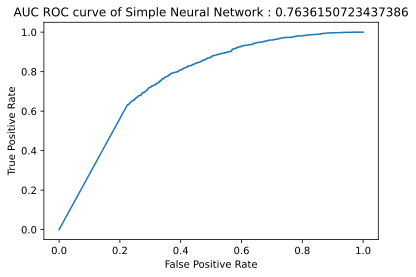

In [48]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_nn)

plot_auc_roc_curve(fpr, tpr, roc_nn, "AUC ROC curve of Simple Neural Network")  

In [49]:
experiments.loc[len(experiments)] = ["Neural Network Classifier", roc_nn]
experiments

,Clf_name,AUC_ROC_score
0,Logistic Regression,0.763847
1,Random Forest,0.749674
2,Neural Network Classifier,0.763615


### Write the predicted values to csv file 'nonglmresults.csv'

In [ ]:
y_prediction_rf = nn_model.predict_proba(df_predict)

pd.DataFrame(y_prediction_rf[:,1]).to_csv(dirpath + "/nonglmresults.csv" , index= False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished


## CNN Classifier

### CNN model definition

In [35]:
n_outputs = 1

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=8, kernel_size=2, activation='relu', input_shape=(X_train_processed.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Dropout(0.7))
cnn_model.add(Flatten())
cnn_model.add(Dense(2, activation='relu'))
cnn_model.add(Dense(n_outputs, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3), metrics=['accuracy'])

In [36]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 8)            24        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 90, 8)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 8)             0         
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 2)                 1442      
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                      

In [37]:
batch_size=6
n_epochs = 150

cnn_hist = cnn_model.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test) , epochs = n_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/150
5334/5334 [==============================] - 23s 4ms/step - loss: 0.4138 - accuracy: 0.8549 - val_loss: 0.3991 - val_accuracy: 0.8549
Epoch 2/150
5334/5334 [==============================] - 22s 4ms/step - loss: 0.4048 - accuracy: 0.8549 - val_loss: 0.3955 - val_accuracy: 0.8549
Epoch 3/150
5334/5334 [==============================] - 20s 4ms/step - loss: 0.4017 - accuracy: 0.8549 - val_loss: 0.3974 - val_accuracy: 0.8549
Epoch 4/150
5334/5334 [==============================] - 19s 4ms/step - loss: 0.3982 - accuracy: 0.8549 - val_loss: 0.3898 - val_accuracy: 0.8549
Epoch 5/150
5334/5334 [==============================] - 25s 5ms/step - loss: 0.3954 - accuracy: 0.8549 - val_loss: 0.3923 - val_accuracy: 0.8549
Epoch 6/150
5334/5334 [==============================] - 20s 4ms/step - loss: 0.3953 - accuracy: 0.8549 - val_loss: 0.3838 - val_accuracy: 0.8549
Epoch 7/150
5334/5334 [==============================] - 22s 4ms/step - loss: 0.3947 - accuracy: 0.8549 - val_loss: 0.3876 -

#### Plot the loss and accuracy curve for train vs test

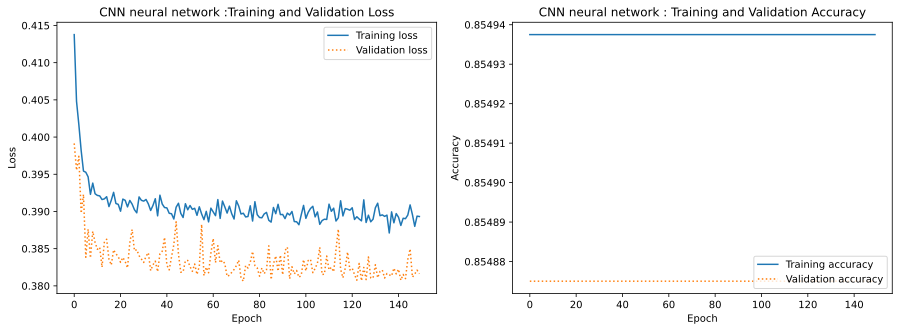

In [38]:
plot_loss_accuracy(cnn_hist,n_epochs, "CNN neural network :" )

#### CNN model prediction

In [39]:
# predict the test data
y_pred_cnn = cnn_model.predict(X_test_processed)
roc_cnn = roc_auc_score(y_test, y_pred_cnn)
print("roc_auc_score score on the test set :   ", roc_auc_score(y_test, y_pred_cnn))
y_pred_cnn.shape

250/250 [==============================] - 1s 4ms/step
roc_auc_score score on the test set :    0.7161215902259914


(8000, 1)

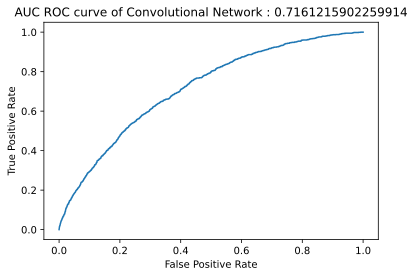

In [40]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_cnn)

plot_auc_roc_curve(fpr, tpr, roc_cnn, "AUC ROC curve of Convolutional Network") 

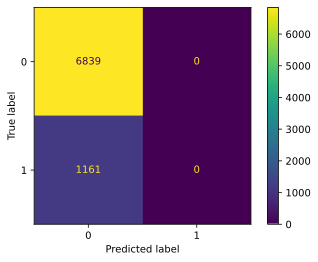

In [41]:
cm = confusion_matrix(y_test, np.argmax(y_pred_cnn, axis=1) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [42]:
experiments.loc[len(experiments)] = ["CNN Classifier", roc_cnn]
experiments

,Clf_name,AUC_ROC_score
0,Logistic Regression,0.763847
1,Random Forest,0.749674
2,Neural Network Classifier,0.763615
3,CNN Classifier,0.716122


# Best Performing Model

# References

1. time.strftime(format[, t])   - https://docs.python.org/3/library/time.html
  ```
   time.strptime('friday', "%A").tm_wday
   ```
2. https://www.geeksforgeeks.org/python-time-strptime-function/
3. https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
4. https://stackoverflow.com/questions/72749144/scikit-learn-pipeline-with-smote


In [43]:
# !wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
# from colab_pdf import colab_pdf
# colab_pdf(dirpath + '/SF_exercise_v3.ipynb')

In [44]:
# !jupyter nbconvert --to PDF "/content/SF_exercise_v3.ipynb"

In [45]:
# %%shell
# jupyter nbconvert --execute --to pdf /content/SF_exercise_v3.ipynb

In [46]:
# %%shell
# jupyter nbconvert --execute --to html /content/SF_exercise_v3.ipynb